# Animal Image Recognition

Ethan Pinto

## Enviroment Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchsummary import summary

import fastai
from fastai.losses import BaseLoss
from fastai.vision.all import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cpu":
    print("WARNING: CUDA is not enabled")
else:
    print("CUDA is enabled")

Set the random seed for reproducibility

In [4]:

SEED = 49

## Pre-process data

Image loaded successfully


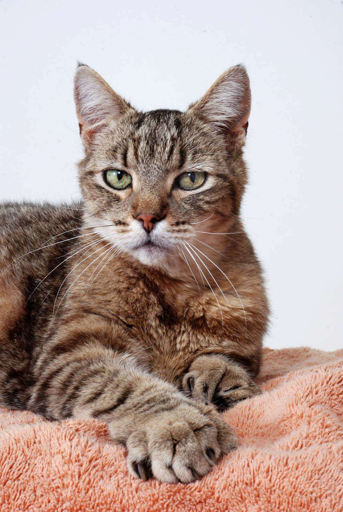

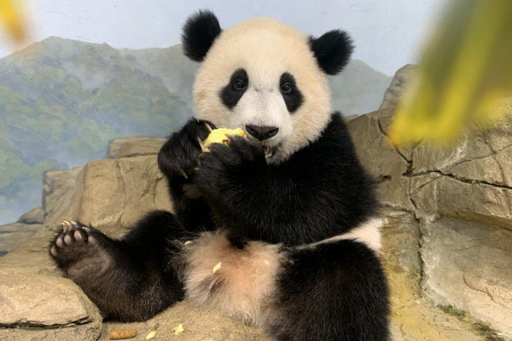

In [5]:
try:
    test_cat = PILImage.create('animals/cat/0b54dde5f5.jpg')
    test_panda = PILImage.create('animals/panda/0d68b6adcb.jpg')
    print("Image loaded successfully")
    display(test_cat.to_thumb(512,512))
    display(test_panda.to_thumb(512,512))
except FileNotFoundError:
    print("File not found. Please make sure the dataset is downloaded and extracted into correct path")

### Make images the same size so they can be used in a Neural Network.

In [6]:
resize = Resize(128, method='squish')

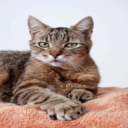

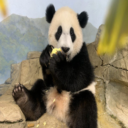

In [7]:
display(resize(test_cat))
display(resize(test_panda))

### Get the Paths and Labels

In [8]:
PATH_NAME = 'raw-img'

paths = []
labels = []
unique_labels_len = 0

for animal in Path(PATH_NAME).ls():
    unique_labels_len += 1
    for image in animal.ls():
        paths.append(image)
        labels.append(animal.name)

print("Length of paths: ", len(paths))
print("Length of labels: ", len(labels))
print("Unqiue labels: ", unique_labels_len)

display(paths[:5])
display(labels[:5])
display(paths[-5:])
display(labels[-5:])

paths = np.array(paths)
labels = np.array(labels)

Length of paths:  26179
Length of labels:  26179
Unqiue labels:  10


[Path('raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg'),
 Path('raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg'),
 Path('raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg'),
 Path('raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg'),
 Path('raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg')]

['cane', 'cane', 'cane', 'cane', 'cane']

[Path('raw-img/scoiattolo/OIP-_U7JiIoYjbWPqmmmmdsvJwHaF5.jpeg'),
 Path('raw-img/scoiattolo/OIP-_VBkNQd_MZI4xoemUb-FtAHaE7.jpeg'),
 Path('raw-img/scoiattolo/OIP-_WyHKgREia-4VijlL6DNswHaFj.jpeg'),
 Path('raw-img/scoiattolo/OIP-_xFGMN0UbYduHdiXQ1maZAHaIF.jpeg'),
 Path('raw-img/scoiattolo/OIP-_XkUFCI2duAyKDD9utKQzgHaFc.jpeg')]

['scoiattolo', 'scoiattolo', 'scoiattolo', 'scoiattolo', 'scoiattolo']

### Split Up Paths

Makes sure that animals are split up evenly, especially since there aren't many.

In [9]:
tts = TrainTestSplitter(test_size=0.2, stratify=labels, random_state=SEED)

In [10]:
train_idx, test_idx = tts(paths)
train_idx, test_idx

((#20943) [8433,19093,4211,21581,4189,25809,22939,11307,13569,17275...],
 (#5236) [12032,3604,13958,21927,8603,13722,8707,25662,22424,20982...])

In [11]:
train_paths = paths[train_idx]
test_paths = paths[test_idx]

### Use DataBlock to Manage Data

In [12]:
animals_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(seed=SEED),
    get_y=parent_label,
    item_tfms=Resize(128, method="squish"),
)

In [13]:
train_dls = animals_db.dataloaders(train_paths, bs=128)

train_dls.train_ds, train_dls.valid_ds

((#16755) [(PILImage mode=RGB size=300x225, TensorCategory(2)),(PILImage mode=RGB size=300x225, TensorCategory(1)),(PILImage mode=RGB size=300x225, TensorCategory(7)),(PILImage mode=RGB size=300x279, TensorCategory(0)),(PILImage mode=RGB size=300x171, TensorCategory(4)),(PILImage mode=RGB size=300x239, TensorCategory(8)),(PILImage mode=RGB size=300x252, TensorCategory(8)),(PILImage mode=RGB size=288x300, TensorCategory(0)),(PILImage mode=RGB size=225x300, TensorCategory(1)),(PILImage mode=RGB size=300x283, TensorCategory(8))...],
 (#4188) [(PILImage mode=RGB size=300x207, TensorCategory(7)),(PILImage mode=RGB size=300x207, TensorCategory(0)),(PILImage mode=RGB size=300x200, TensorCategory(8)),(PILImage mode=RGB size=293x300, TensorCategory(0)),(PILImage mode=RGB size=260x300, TensorCategory(3)),(PILImage mode=RGB size=300x222, TensorCategory(5)),(PILImage mode=RGB size=300x198, TensorCategory(8)),(PILImage mode=RGB size=300x190, TensorCategory(7)),(PILImage mode=RGB size=300x251, Tenso

**NOTE:** Resize will happen when batching happens (It happens lazily).

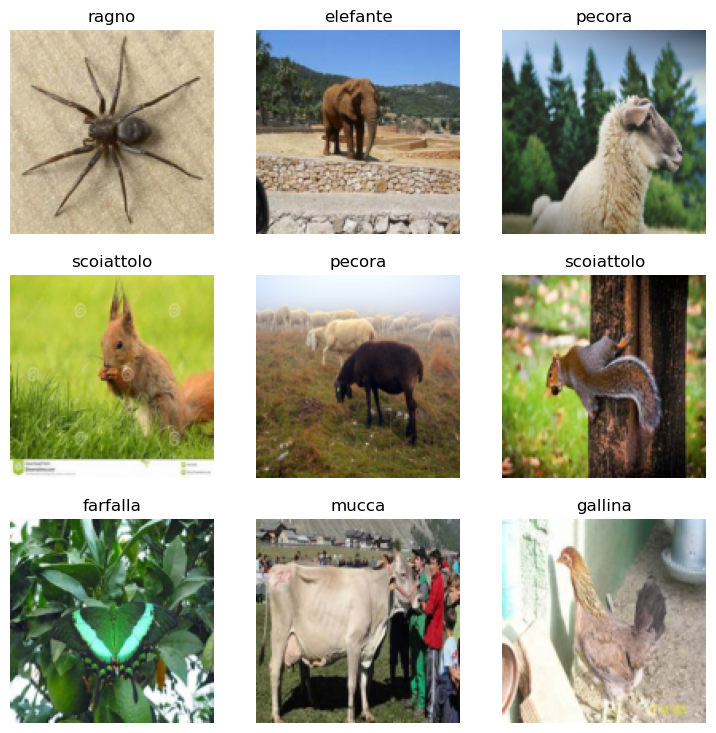

In [14]:
x, y = train_dls.one_batch()
train_dls.show_batch()

## Convolutional Neural Network (CNN)

### Building Layers

In [15]:
cnn_layers = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
).to(device)

cnn_out = cnn_layers(x)

cnn_out.shape

torch.Size([128, 128, 14, 14])

In [16]:
fc_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(128*14*14, 128),
    nn.ReLU(),
    nn.Linear(128, unique_labels_len),
    nn.LogSoftmax(dim=1)
).to(device)

fc_out = fc_layers(cnn_out)

fc_out.shape

torch.Size([128, 10])

In [17]:
model = nn.Sequential(*cnn_layers, *fc_layers)

In [18]:
summary(model, x.shape[1:]);

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
              ReLU-2         [-1, 32, 126, 126]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          18,496
              ReLU-5           [-1, 64, 61, 61]               0
         MaxPool2d-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
              ReLU-8          [-1, 128, 28, 28]               0
         MaxPool2d-9          [-1, 128, 14, 14]               0
          Flatten-10                [-1, 25088]               0
           Linear-11                  [-1, 128]       3,211,392
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
       LogSoftmax-14                   

### Training

In [19]:
nll_loss = BaseLoss(nn.NLLLoss)

nll_loss.decodes = lambda x: x.argmax(axis=1)

for name, layer in model.named_children():
    if hasattr(layer, 'reset_parameters'):
        # print(name)
        layer.reset_parameters()

learn = Learner(train_dls, model, opt_func=Adam, loss_func=nll_loss, metrics=accuracy)

In [20]:
learn.fit(3, .001)

epoch,train_loss,valid_loss,accuracy,time
0,1.830743,1.661781,0.428844,04:36
1,1.515717,1.446317,0.505253,11:27
2,1.318052,1.351949,0.541547,04:32


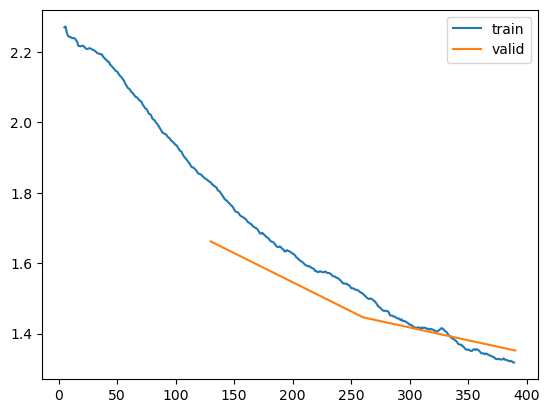

In [21]:
learn.recorder.plot_loss()

In [22]:
test_dl = train_dls.test_dl(test_items=test_paths, with_labels=True)

In [23]:
test_loss, tst_acc = learn.validate(dl=test_dl)

In [24]:
test_logprobs, tst_targets = learn.get_preds(dl=test_dl)

test_preds = test_logprobs.argmax(axis=1)
tst_incorrect_preds = torch.where((tst_targets == test_preds) == False)[0]


print("Test Loss: ", test_loss)
print("Test Accuracy: ", tst_acc)
print("Incorrect Predictions: {}".format(len(tst_incorrect_preds)))

Test Loss:  1.3269895315170288
Test Accuracy:  0.5548128485679626
Incorrect Predictions: 2331
